In [1]:
import itertools
import cv2
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
import src.mymodel.gmm as mygmm
import torch
import time
from sklearn import mixture
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2



In [2]:
color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])


def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(1, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        if v[1]/v[0]<4:
            continue
            
#         plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
        plt.axis('equal')
    plt.xlim(500,1400)
    plt.ylim(250,800)
    plt.title(title)



(1055, 1920)
(29481, 2)


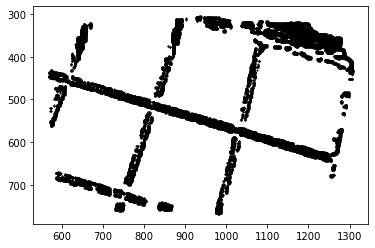

In [3]:
img = cv2.imread('data/point_cloud_to_image.png',cv2.IMREAD_GRAYSCALE)
bitmap = img < 100
H,W = bitmap.shape
print(bitmap.shape)
U = np.array([range(W) for _ in range(H)])
V = np.array([range(H) for _ in range(W)]).T
u = U[bitmap]
v = V[bitmap]

X = np.c_[u,v].astype(np.float)
plt.scatter(X[:,0],X[:,1],s=1,color='k')
plt.gca().invert_yaxis()
print(X.shape)

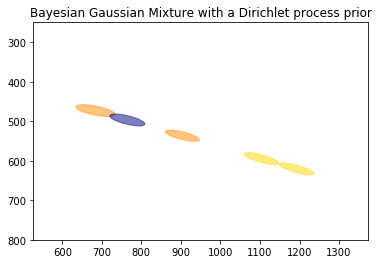

In [4]:
# Fit a Gaussian mixture with EM using five components
# gmm = mixture.GaussianMixture(n_components=10, covariance_type="full").fit(X)
# plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0, "Gaussian Mixture")

# # Fit a Dirichlet process Gaussian mixture using five components
dpgmm = mixture.BayesianGaussianMixture(n_components=30, covariance_type="full",max_iter =3).fit(X)
plot_results(
    X,
    dpgmm.predict(X),
    dpgmm.means_,
    dpgmm.covariances_,
    0,
    "Bayesian Gaussian Mixture with a Dirichlet process prior",
)

plt.gca().invert_yaxis()

plt.show()


In [5]:
my_gmm = mygmm.GMM(n_components=30, max_iter =30)
my_gmm.fit(X);
my_gmm.filter_GMM(X,filter_ratio=0);#my_gmm.merge_GMM(X);


(29481, 1)


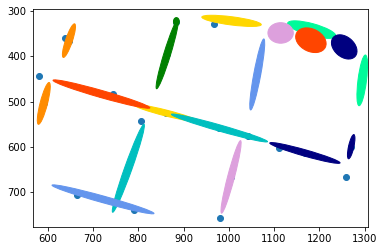

In [7]:
my_gmm.plot_results(X,'filter_list')
plt.xlim(X[:,0].min(),X[:,0].max())
plt.ylim(X[:,1].min(),X[:,1].max())
plt.gca().invert_yaxis()
plt.scatter(my_gmm.mu[:,0],my_gmm.mu[:,1])
print(my_gmm.weights[:, [1]].shape)


#### test kmeans-torch

torch.Size([1, 29481, 2])


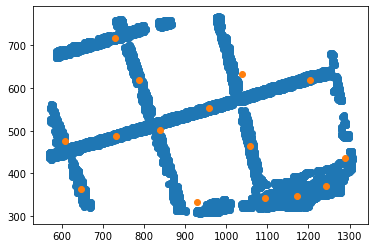

In [8]:
# import torch
tstart = time.time()
X_tensor = torch.from_numpy(X).unsqueeze(0)
print(X_tensor.shape)
cl,c = mygmm.kmeans(X_tensor,K=15,Niter=10)

plt.scatter(X[:,0],X[:,1])
plt.scatter(c[:,0],c[:,1])

#### test covariance-torch

In [ ]:
# B,N,D = 2,100,2
# X = torch.rand(1,N,D)
# # aweights = torch.full((B,N),1/N)
# aweights = torch.rand(B,N)
# aweights = aweights/aweights.sum(dim=1).unsqueeze(1)
# # 
# # X = torch.tensor([[[1],[2],[3],[4],[5]]])
# # B,N,D = X.shape
# # aweights = torch.tensor([[0.25,0.25,0.1,0.25,0.25]])

# bcov = mygmm.bcov(X,aweights=aweights)


# bcov2 = [];bmean2 = []
# for i in range(B):
#     covi = torch.cov(X[0,:,:].T,aweights=aweights[i,:])
#     bcov2.append(covi)
# bcov2 = torch.cat(bcov2).reshape(B,D,D)


# print(bcov)
# print('**********')
# print(bcov2)
# print('**********')

# print(bcov/bcov2)



#### Test GMM-Torch

In [89]:
X_tensor = torch.from_numpy(X).unsqueeze(0).cuda()
my_gmm = mygmm.GMM_torch(n_components=20, max_iter =30)
my_gmm.fit(X_tensor);
my_gmm.filter_GMM(X_tensor,filter_ratio=4);
my_gmm.merge_GMM(X_tensor)

cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu


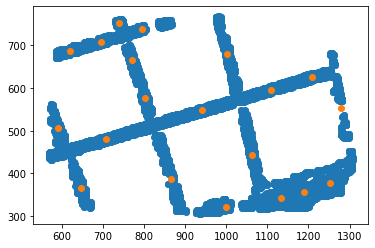

In [92]:
centroids = my_gmm.mu.cpu()
plt.scatter(X_tensor[0,:,0].cpu(),X_tensor[0,:,1].cpu())
plt.scatter(centroids[:,0,0],centroids[:,0,1])

tensor(0.3310, device='cuda:0', dtype=torch.float64)
tensor([[ 139.1768, -558.6803],
        [-558.6803, 2898.2755]], device='cuda:0', dtype=torch.float64)


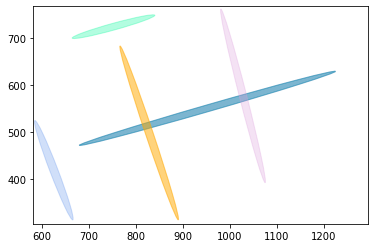

In [94]:
my_gmm.plot_results(X,gmm_list='merge_list')
plt.gca().invert_yaxis()
i = 15
# plt.scatter(my_gmm.mu[i,0,0],my_gmm.mu[i,0,1],100,'r')
# plt.scatter(X_tensor[0,:,0],X_tensor[0,:,1],0.001,color='k')
print(my_gmm.phi[i]/my_gmm.phi.max())
print(my_gmm.sigma[i])

In [91]:
for l in my_gmm.merge_list:
    for i,ll in enumerate(l[1:]):
        if ll.device != torch.device('cpu'):
            print(i,ll)